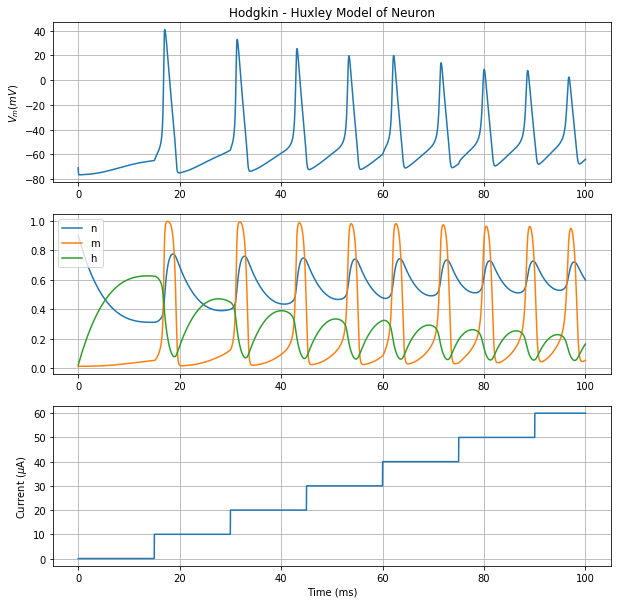

In [16]:
##Hogkin - Huxley Model
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#Defining Constants
Cm = 1.0 #uF/sqcm
ENa = 50.0 #mV
EK = -77.0 #mV
Eleak = -54.387 #mV
gNa = 120.0 #mS/sqcm
gK = 36.0 #mS/sqcm
gleak = 0.3 #mS/sqcm

#Defining Functions:
def IK(V, n): #Potassium Current
    return gK*(V - EK)*n**4

def INa(V, m, h): #Sodium Current
    return gNa*h*(V - ENa)*m**3

def Ileak(V): #Leak Current
    return gleak*(V - Eleak)

def KParameters(V):  #Voltage dependent transition rate
    an = (0.01*(V + 55.0))/(1 - np.exp(-(V + 55.0)/10.0)) #alpha_n
    bn = 0.125*np.exp(-(V +65.0)/80.0)
    
    return an, bn

def NaParameters(V):
    am = (0.1*(V + 40.))/(1 - np.exp(-(V + 40.)/10.)) 
    bm = 4*np.exp(-(V + 65)/18)
    
    ah = 0.07*np.exp(-(V + 65.)/20.)
    bh = 1.0/((np.exp(-(V + 35.)/10.))+1)
    
    return am ,bm, ah, bh

def Iinj(t):  #INPUT CUURENT
    #if (0<t<25):
     #   return 10
    #if (40<t<65):
      #  return 20
    #if (80<t<100):
       # return 60
    #else:
      #  return 0
    
    return 10*np.floor(t/15)

#State Function
def dXdt(X, t):
    V = X[0]
    n = X[1]
    m = X[2]
    h = X[3]
    
    an, bn = KParameters(V)
    am, bm, ah, bh = NaParameters(V)
    
    dVdt = (Iinj(t) - IK(V, n) - INa(V, m, h) - Ileak(V))/Cm
    dndt = an*(1-n) - bn*(n)
    dmdt = am*(1-m) - bm*(m)
    dhdt = ah*(1-h) - bh*(h)
    
    return dVdt, dndt, dmdt, dhdt  #Checkpoint!! Do not return X

#Defining Initial Conditions
y0 = np.array([-71., 0.9, 0.01, 0.02])
epsilon = 0.01
t = np.arange(0., 100., epsilon)
y = np.zeros((y0.shape[0], t.shape[0]))
y[:,0] = y0
I = [Iinj(t) for t in t]

#Integrating function
sol = odeint(dXdt, y0, t)

######PLOTTING###########

plt.figure(figsize=(10,10))

#Action Potential
plt.subplot(3,1,1)
plt.title("Hodgkin - Huxley Model of Neuron")
plt.plot(t, sol[:,0])
plt.ylabel('$V_{m}(mV)$')
plt.grid()

#transition rates
plt.subplot(3,1,2)
plt.plot(t, sol[:,1], label = "n")
plt.plot(t, sol[:,2], label ="m")
plt.plot(t, sol[:,3], label = "h")
plt.legend()
plt.grid()

#input Current
plt.subplot(3,1,3)
plt.plot(t, I)
plt.ylabel("Current ($\mu$A)")
plt.xlabel("Time (ms)")
plt.plot()
plt.grid()
plt.show()


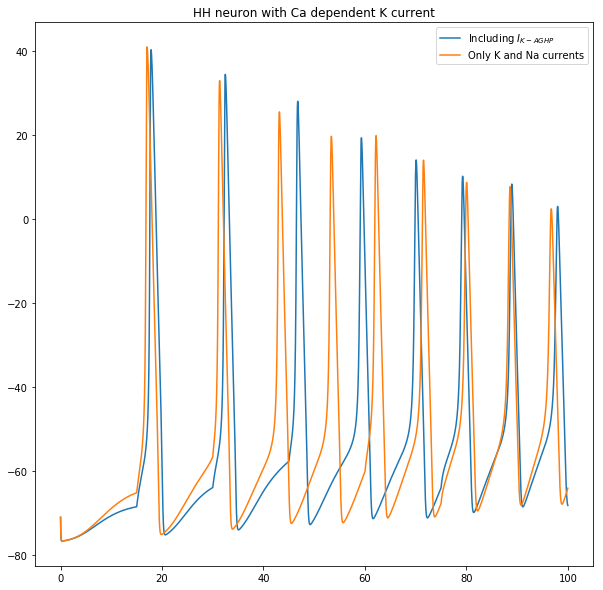

In [22]:
##Incorporating After-hyperpolarization current IK(AHP)
##Calcium - Dependent Potassium channel is slow acting and allows more K+ to flow out during hyperpolariazation
##This causes a large undershoot in the action potential profile

#Constants for Ca dependent K channels
gkAGP = 0.7 #mS/sqcm
F = 9.6485e4 #C/mol
R = 8.314 #J/mol.K
T = 310.0 #K
alpha = 480 #s-1
beta = 280 #s-1
k1 = 0.18 #mM
k2 = 0.011 #mM
d1 = 0.84
d2 = 1
#Current
def IkAHP(V, O):
    return gkAGP*O*(V - EK)

#Parameters

#Approximate the Ca concentration by gaussian random generator, mean = 10uM, SD = 0.4246e-3 ms

def CaConc():
    return np.random.normal(0.25, 0.5)

def CaParameters(V):
    Ca = CaConc()
    
    a = alpha/(1 + k1*np.exp(-(2*d1*F*V/R*T))/Ca)
    b = beta/(1 + k2*Ca*np.exp(-(2*d2*F*V/R*T)))
    
    return a, b

def CadXdt(X , t):
    V = X[0]
    n = X[1]
    m = X[2]
    h = X[3]
    O = X[4]
    
    an, bn = KParameters(V)
    am, bm, ah, bh = NaParameters(V)
    a, b = CaParameters(V)
    
    dVdt = (Iinj(t) - IK(V, n) - INa(V, m, h) - Ileak(V) - IkAHP(V, O))/Cm
    dndt = an*(1-n) - bn*(n)
    dmdt = am*(1-m) - bm*(m)
    dhdt = ah*(1-h) - bh*(h)
    dOdt = a*(1 - O) - b*O
    
    return dVdt, dndt, dmdt, dhdt, dOdt  #Checkpoint!! Do not return X

#Integrating
x0 =  np.array([-71., 0.9, 0.01, 0.02, 0.4])
sol2 = odeint(CadXdt, x0, t)

#plotting
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)

plt.title("HH neuron with Ca dependent K current")
plt.plot(t, sol2[:,0], label="Including $I_{K-AGHP}$")
plt.plot(t, sol[:,0], label="Only K and Na currents")
plt.legend()
plt.show()

#plt.subplot(2,2,2)
#plt.plot(t, sol2[:,4])
#plt.show()



In [7]:
##Bifurcation Diagram for HH Neuron:
##Vary input current from 0uA to 100uA and see the change in the max and min ampitude of membrane potential
##########DO NOT RUN THIS SECTION UNLESS REQUIRED########
#f = open("data.dat", 'w')
top = 200


#State Function
def dXdt(X, t, i, dummy):
    V = X[0]
    n = X[1]
    m = X[2]
    h = X[3]
        
    an, bn = KParameters(V)
    am, bm, ah, bh = NaParameters(V)
    
    dVdt = (i - IK(V, n) - INa(V, m, h) - Ileak(V))/Cm
    dndt = an*(1-n) - bn*(n)
    dmdt = am*(1-m) - bm*(m)
    dhdt = ah*(1-h) - bh*(h)
    
    return dVdt, dndt, dmdt, dhdt  #Checkpoint!! Do not return X

#Defining Initial Conditions
y0 = np.array([-71., 0.9, 0.01, 0.02])
epsilon = 0.01
t = np.arange(0., 100., epsilon)
y = np.zeros((y0.shape[0], t.shape[0]))
y[:,0] = y0
vTrace = np.zeros((t.shape[0], top))

##Keep appending the trace of the membrance potential for each value of input current in the vTrace matrix
#in the end one should have vTrace of size dim(t)x (no. of trials)
#Each column carries the data for a given trial i.e. current input

for i in range(top):  #Very Very Expensive Step!!
    #Calling the Integrating function
    sol = odeint(dXdt, y0, t, args =(i, 0))
    vTrace[:,i] = sol[:,0]

#f.write(vTrace)
f.close()

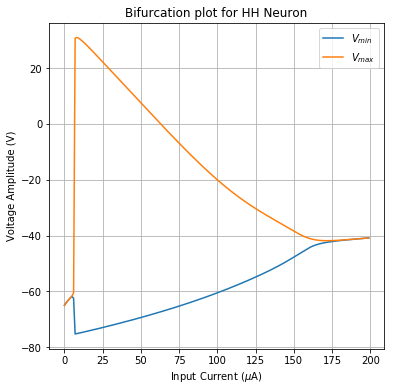

In [8]:
#In this case vTrace is a 10000x100 matrix. 
#Find max and min of vTrace in some time interval far from beginning and end of cycle
minMax = np.zeros((top, 2))
for i in range(top):
    minMax[i,0] = min(vTrace[5000:8000,i])
    minMax[i,1] = max(vTrace[5000:8000,i])
    

Ii = np.arange(top)    

######Plotting#####
plt.figure(figsize=(10,10))
plt.title("Bifurcation plot for HH Neuron")

plt.plot(Ii, minMax[:,0], '-', label="$V_{min}$")
plt.plot(Ii, minMax[:,1],'-', label="$V_{max}$")
plt.xlabel('Input Current ($\mu$A)')
plt.ylabel('Voltage Amplitude (V)')
plt.grid()
plt.legend()
plt.show()


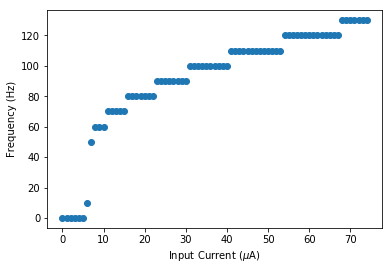

In [11]:
##Variation of Frequency of the spike train produced by a HH neuron in response to the input current
#In theory, as the input current increases, the frequency at which a neuron fires increases 
#however, due to the refractory period (~10ms) after every spike, the neuron cannot react quickly enough for higher inputs
#this results in a plateu in frequency vs. input current characteristics in python
plt.plot(Ii[:75], np.bitwise_and(vTrace[:-1,:75]<-10, vTrace[1:,:75]>-10).sum(axis=0)/0.1, 'o')
plt.xlabel("Input Current ($\mu$A)")
plt.ylabel("Frequency (Hz)")
plt.show()
